In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.path as mpath

import xgcm

In [4]:
from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(r'/Users/khbhavsar/Desktop/PHYS 437A/ECCOv4-py/ECCOv4-py')

import ecco_v4_py as ecco

In [5]:
ECCO_dir = r'/Users/khbhavsar/Desktop/PHYS 437A/downloaded_data'

In [9]:
from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2006-01-09",EndDate="2006-12-31",download_root_dir=ECCO_dir,\
                    n_workers=6,force_redownload=False)

created download directory /Users/khbhavsar/Desktop/PHYS 437A/downloaded_data/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2006-01-09,2006-12-31'}

Total number of matching granules: 1
DL Progress: 100%|###########################| 1/1 [00:02<00:00,  2.90s/it]

total downloaded: 8.57 Mb
avg download speed: 2.95 Mb/s


In [10]:
vel_monthly_shortname = "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vel_monthly_shortname,\
                    StartDate="2006-01-02",EndDate="2006-12-31",download_root_dir=ECCO_dir,\
                    n_workers=6,force_redownload=False)

created download directory /Users/khbhavsar/Desktop/PHYS 437A/downloaded_data/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2006-01-02,2006-12-31'}

Total number of matching granules: 12
DL Progress: 100%|#########################| 12/12 [00:06<00:00,  1.95it/s]

total downloaded: 71.03 Mb
avg download speed: 11.53 Mb/s


In [11]:
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vel_monthly_shortname,\
                    StartDate="2006-01-02",EndDate="2006-12-31",download_root_dir=ECCO_dir,\
                    n_workers=6,force_redownload=False)

created download directory /Users/khbhavsar/Desktop/PHYS 437A/downloaded_data/ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2006-01-02,2006-12-31'}

Total number of matching granules: 12
DL Progress: 100%|#########################| 12/12 [00:11<00:00,  1.05it/s]

total downloaded: 367.38 Mb
avg download speed: 32.04 Mb/s


In [12]:
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

ds_SSH = xr.open_mfdataset(join(ECCO_dir,'*SSH*MONTHLY*','*_2006-*.nc'))
ds_VEL = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VEL*MONTHLY*','*_2006-*.nc'))

ds_UVEL_SSS = ds_VEL.UVEL.isel(k=0)
ds_VVEL_SSS = ds_VEL.VVEL.isel(k=0)

ecco_ds = ecco_grid.copy()

ecco_ds['SSH'] = ds_SSH['SSH']
ecco_ds['VVEL'] = ds_VVEL_SSS
ecco_ds['UVEL'] = ds_UVEL_SSS

## Load ecco_ds into memory
ecco_ds = ecco_ds.load()

In [18]:
# Pick a tile and a time
# Kuroshio current is in 5, and partly in 7
# 0 is January
tile = 5
time = 0

# Define coordinates
XC = ecco_grid.XC.isel(tile=tile)
XG = ecco_grid.XG.isel(tile=tile)
YC = ecco_grid.YC.isel(tile=tile)
YG = ecco_grid.YG.isel(tile=tile)

Text(0, 0.5, 'y -->')

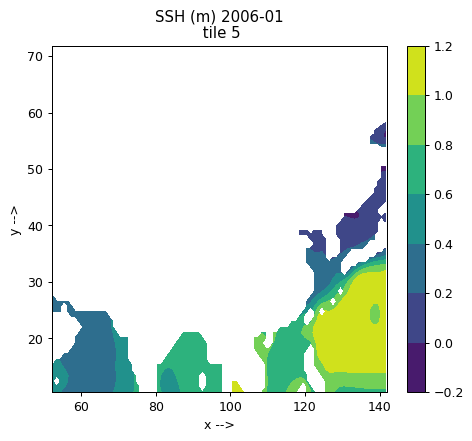

In [20]:
plt.figure(figsize=(6,5), dpi= 90)
plt.contourf(XC, YC, ecco_ds.SSH.isel(tile=tile, time=time), origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
plt.title('SSH (m) ' + str(ecco_ds.time[0].values)[0:7] + '\n tile ' + str(tile))
plt.xlabel('x -->')
plt.ylabel('y -->')

In [21]:
XGCM_grid = ecco.get_llc_grid(ecco_ds)

xfld = ecco_ds.UVEL.isel(time=time)
yfld = ecco_ds.VVEL.isel(time=time)

velc = XGCM_grid.interp_2d_vector({'X': xfld, 'Y': yfld},boundary='fill')

VEL_E  = velc['X']*ecco_ds['CS'] - velc['Y']*ecco_ds['SN']
VEL_N  = velc['X']*ecco_ds['SN'] + velc['Y']*ecco_ds['CS']

SPEED = np.sqrt(VEL_E**2 + VEL_N**2)

In [38]:
velc

{'X': <xarray.DataArray 'VVEL' (tile: 13, j: 90, i: 90)>
 array([[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [ 0.05461122,  0.05415548,  0.05634172, ...,  0.05145428,
           0.05448624,  0.05742973],
         [ 0.06353323,  0.06762001,  0.07209031, ...,  0.04369236,
           0.04668709,  0.05055984],
         [ 0.0747468 ,  0.08067195,  0.08389942, ...,  0.03942559,
           0.04276099,  0.04768088]],
 
        [[ 0.08371362,  0.08788775,  0.08615239, ...,  0.03782565,
           0.04085008,  0.04612652],
         [ 0.08243902,  0.0829016 ,  0.07583059, ...,  0.03711058,
           0.03835533,  0.04224305],
         [ 0.06763776,  0.06402879,  0.0533104 , ...,  0.04063999,
           0.03923988,  0.0

Text(0, 0.5, 'y -->')

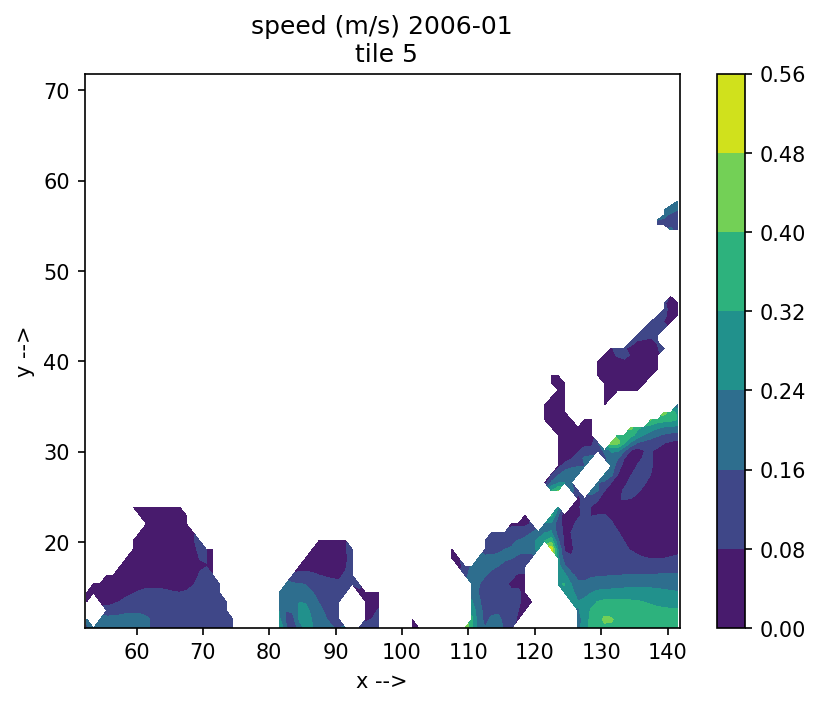

In [25]:
plt.figure(dpi= 150)
plt.contourf(XC, YC, SPEED.isel(tile=tile), origin='lower');

plt.colorbar()
plt.title('speed (m/s) ' + str(ecco_ds.time[0].values)[0:7] + '\n tile ' + str(tile))
plt.xlabel('x -->')
plt.ylabel('y -->')

In [26]:
print(np.max(SPEED.isel(tile=tile)))
print(np.min(SPEED.isel(tile=tile)))

<xarray.DataArray ()>
array(0.5496828, dtype=float32)
Coordinates:
    tile     int32 5
<xarray.DataArray ()>
array(0.00547128, dtype=float32)
Coordinates:
    tile     int32 5


In [27]:
print(np.max(SPEED))
print(np.min(SPEED))

<xarray.DataArray ()>
array(1.0136973, dtype=float32)
<xarray.DataArray ()>
array(0.00011001, dtype=float32)


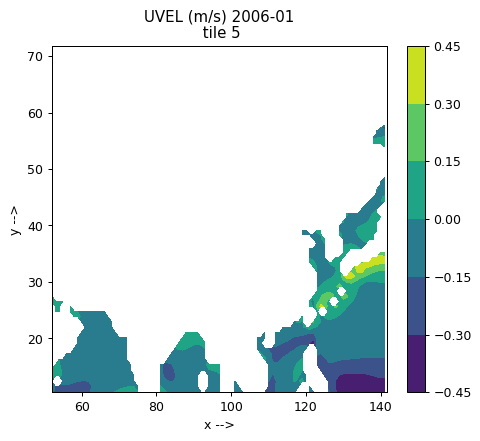

In [28]:
plt.figure(figsize=(6,5), dpi= 90)
plt.contourf(XG, YC, ecco_ds.UVEL.isel(tile=tile, time=time), origin='lower');

plt.colorbar()
plt.title('UVEL (m/s) ' + str(ecco_ds.time[0].values)[0:7] + '\n tile ' + str(tile))
plt.xlabel('x -->')
plt.ylabel('y -->')

if tile==10:
    point1 = [-75, 40]
    point2 = [-65, 32]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, linestyle="--", color = "red")

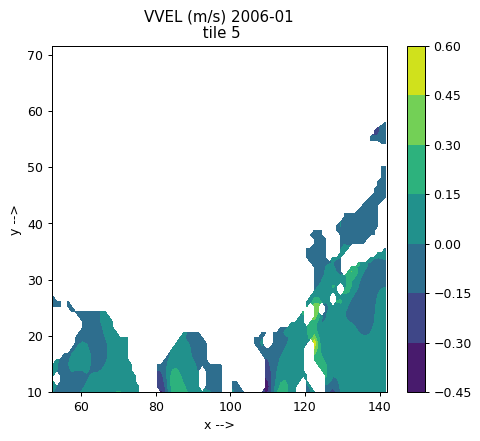

In [29]:
plt.figure(figsize=(6,5), dpi= 90)
plt.contourf(XC, YG, ecco_ds.VVEL.isel(tile=tile, time=time), origin='lower');

plt.colorbar()
plt.title('VVEL (m/s) ' + str(ecco_ds.time[0].values)[0:7] + '\n tile ' + str(tile))
plt.xlabel('x -->')
plt.ylabel('y -->')

if tile==10:
    point1 = [-75, 40]
    point2 = [-65, 32]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, linestyle="--", color = "red")

In [30]:
print(np.max(ecco_ds.UVEL.isel(tile=10)))
print(np.min(ecco_ds.UVEL.isel(tile=10)))

ecco_ds.UVEL

<xarray.DataArray 'UVEL' ()>
array(0.3811321, dtype=float32)
Coordinates:
    tile     int32 10
<xarray.DataArray 'UVEL' ()>
array(-0.42318007, dtype=float32)
Coordinates:
    tile     int32 10


<xarray.DataArray 'UVEL' (time: 12, tile: 13, j: 90, i_g: 90)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [ 5.59338443e-02,  5.32885976e-02,  5.50223552e-02, ...,
           4.97696474e-02,  5.31389043e-02,  5.58335893e-02],
         [ 6.21633045e-02,  6.49031550e-02,  7.03368559e-02, ...,
           4.22899686e-02,  4.50947471e-02,  4.82794382e-02],
         [ 7.17625543e-02,  7.77310580e-02,  8.36128443e-02, ...,
           3.80829982e-02,  4.07681800e-02,  4.47538085e-02]],

        [[ 8.06533173e-02,  8.67739320e-02,  8.90015736e-02, ...,
           3.68600935e-02,  3.87912057e-02,  4.29089516e-02],
         [ 8.04684609e-02,  8.44095871e-02,  8.13935995e-02, ...,
           3.70876193e-02,  3.71335447e-02,  3.95771116e-02],
         [ 6.76371381e-02,  6.76383823e-02,  6.04192056e-02, ...,
           4.16196026e-02,  3.96603718e-02,  3.88193913e-02],
...
          -5.00187092e-02, -5.59948049e-02, -6.37255907e-02],
         [-8.59295279e-02, -9.59164575e-02, -1.05333284e-01, ...,
          -4.18108925e-02, -5.07480055e-02, -6.29386902e-02],
         [-8.32417160e-02, -9.15141553e-02, -9.60785300e-02, ...,
          -3.11275944e-02, -3.78436558e-02, -4.86116707e-02]],

        [[-5.40710799e-02, -6.31988719e-02, -6.79455549e-02, ...,
                      nan,             nan,             nan],
         [-7.35653564e-02, -7.89211392e-02, -8.01700354e-02, ...,
                      nan,             nan,             nan],
         [-8.25918168e-02, -8.39261785e-02, -8.30241069e-02, ...,
                      nan,             nan,             nan],
         ...,
         [-6.60662428e-02, -6.28673434e-02, -5.62665612e-02, ...,
                      nan,             nan,             nan],
         [-7.08727017e-02, -7.34915733e-02, -7.06480294e-02, ...,
                      nan,             nan,             nan],
         [-5.63758202e-02, -6.11820817e-02, -6.24854974e-02, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2006-01-16T12:00:00 ... 2006-12-16T12:00:00
Attributes:
    long_name:              Horizontal velocity in the model +x direction
    units:                  m s-1
    mate:                   VVEL
    coverage_content_type:  modelResult
    direction:              >0 increases volume
    standard_name:          sea_water_x_velocity
    comment:                Horizontal velocity in the +x direction at the 'u...
    valid_min:              -1.2937312126159668
    valid_max:              1.776294231414795

In [31]:
print(np.max(ecco_ds.VVEL.isel(tile=10)))
print(np.min(ecco_ds.VVEL.isel(tile=10)))

ecco_ds.VVEL

<xarray.DataArray 'VVEL' ()>
array(0.44442803, dtype=float32)
Coordinates:
    tile     int32 10
<xarray.DataArray 'VVEL' ()>
array(-0.45337182, dtype=float32)
Coordinates:
    tile     int32 10


<xarray.DataArray 'VVEL' (time: 12, tile: 13, j_g: 90, i: 90)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [ 4.07340862e-02,  2.95579657e-02,  2.41853669e-02, ...,
           6.15950674e-03,  1.10316705e-02,  1.35811390e-02],
         [ 4.35637534e-02,  2.88422965e-02,  2.25940365e-02, ...,
           2.86211725e-03,  7.43164169e-03,  9.24865901e-03],
         [ 4.10061032e-02,  2.41721272e-02,  1.93481818e-02, ...,
          -1.50051049e-03,  1.53619121e-03,  1.57267286e-03]],

        [[ 3.47580537e-02,  1.79616455e-02,  1.83058921e-02, ...,
          -6.33579073e-03, -5.87715488e-03, -8.36819224e-03],
         [ 2.78263390e-02,  1.37929115e-02,  2.32808627e-02, ...,
          -1.08513236e-02, -1.35148251e-02, -1.88430380e-02],
         [ 2.24405713e-02,  1.41577870e-02,  3.47326025e-02, ...,
          -1.31286960e-02, -1.88009255e-02, -2.71381103e-02],
...
           4.68971208e-02,  6.12469055e-02,  7.66721070e-02],
         [-8.50710347e-02, -4.55459319e-02,  3.29630543e-03, ...,
           4.97539118e-02,  6.32010698e-02,  7.36637488e-02],
         [-7.80439749e-02, -3.69559973e-02,  1.23946108e-02, ...,
           5.72018661e-02,  7.04961047e-02,  7.56519064e-02]],

        [[ 1.45173565e-01,  1.44408822e-01,  1.40360638e-01, ...,
                      nan,             nan,             nan],
         [ 1.52488306e-01,  1.48458600e-01,  1.38398856e-01, ...,
                      nan,             nan,             nan],
         [ 1.56394616e-01,  1.49238780e-01,  1.34079039e-01, ...,
                      nan,             nan,             nan],
         ...,
         [ 8.65436643e-02,  9.49300081e-02,  9.80629995e-02, ...,
                      nan,             nan,             nan],
         [ 7.79008865e-02,  8.36708546e-02,  8.79995823e-02, ...,
                      nan,             nan,             nan],
         [ 7.29520693e-02,  7.34483823e-02,  7.51739442e-02, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2006-01-16T12:00:00 ... 2006-12-16T12:00:00
Attributes:
    long_name:              Horizontal velocity in the model +y direction
    units:                  m s-1
    mate:                   UVEL
    coverage_content_type:  modelResult
    direction:              >0 increases volume
    standard_name:          sea_water_y_velocity
    comment:                Horizontal velocity in the +y direction at the 'v...
    valid_min:              -1.2608345746994019
    valid_max:              1.4756959676742554